In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import torch
current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

# fmt: on

from PIL import Image
import tempfile
import time
import warnings
from transformers import AutoTokenizer
import cv2
import numpy as np
import tqdm
import torch
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.projects.hipie.demo_lib.demo_utils import *
from scipy.ndimage import distance_transform_edt, label as ndi_label
# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from detectron2.data.detection_utils import read_image,convert_PIL_to_numpy
from detectron2.projects.hipie.data.coco_dataset_mapper_uni import cat2ind as cat2ind_fun

/home/kkallidromitis/universal/hipie/notebooks


In [3]:
def custom_demo(cfg,test_categories,metadata=None):
    demo = VisualizationDemo(cfg,test_categories,metadata)
    model = demo.predictor.model
    model.use_bg_for_pano = True
    model.clip_alpha = 0.2
    model.clip_beta = 0.45
    model.object_mask_threshold = 0.25
    model.overlap_threshold = 0.8
    model.pano_temp_fg = 0.01
    model.pano_temp = 0.06
    return demo,model


args = Namespace()
args.config_file = 'projects/HIPIE/configs/eval/image_joint_vit_huge_32g_pan_maskdino_ade_test.yaml'
args.opts = ['OUTPUT_DIR','outputs/test_maskdino_pan_fixed_lan']
args.task = "detection"
cfg = setup_cfg(args,'weights/vit_h_cloud.pth')

In [4]:
def make_custom_metadata(metadata,custom_categories,custom_categories_is_thing,custom_categories_no_prompt):
    
    thing_classes = []
    stuff_tmp = []
    
    for i in range(len(custom_categories)):
        if custom_categories_is_thing[i+1]:
            thing_classes.append(custom_categories_no_prompt[i]['name'])
        else:
            stuff_tmp.append(custom_categories_no_prompt[i]['name'])
            
    stuff_classes = thing_classes.copy()
    stuff_classes.extend(stuff_tmp)
    
    thing_colors = metadata.thing_colors[:len(thing_classes)]
    stuff_colors = metadata.thing_colors[:len(stuff_classes)]
    return thing_classes,thing_colors,stuff_classes,stuff_colors

In [5]:
#Stuff ALWAYS at the end
definition_file = '''
1:thing:person,child,girl,boy,woman,man,people,children,girls,boys,women,men,lady,guy,ladies,guys,clothes
2:thing:rider,driver
3:thing:car,automobile,cars
4:thing:truck,trucks,motortruck
5:thing:bus,buses,autobus,double-decker,jitney,motorbus,motorcoach,omnibus,passenger vehicle
6:thing:train,trains,locomotive,locomotives,freight train
7:thing:motorcycle,motorcycles
8:thing:bicycle,bicycles,bike,bikes
9:thing:bird,birds
10:thing:traffic light,traffic signal,traffic lights
11:thing:swimsuit
12:stuff:pole,flagpole,beam
13:stuff:fence,fences,fencing
14:stuff:wall,walls,brick wall,wood wall,tile wall,stone wall
15:stuff:building,buildings,skyscraper,skyscrapers
16:stuff:road,route,street,roads,streets,routes
17:stuff:sky,clouds
18:stuff:vegetation,grass,plant,flora,plant life,plants,bushes
19:stuff:tree,trees,palm tree
20:stuff:pavement,sidewalk
21:stuff:sea,water
'''

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('projects/HIPIE/bert-base-uncased')
lines = definition_file.splitlines()

custom_categories = []
custom_categories_is_thing = {}
custom_categories_is_thing[0] = False
cid = 1
for line in lines:
    if not line:
        continue
    id,is_thing_cls,name = line.split(":")
    custom_categories_is_thing[cid] = is_thing_cls=='thing'
    cid += 1
    if name == 'invalid_class_id':
        continue
    custom_categories.append({"id": int(id), "name": name})

custom_categories_no_prompt = [{'id':custom_categories[i]['id'], 'name':custom_categories[i]['name'].split(',')[0]} 
                               for i in range(len(custom_categories))]

test_args_custom = dict(
    test_categories=custom_categories_no_prompt, # for BERT, dont use ensemble
    open_seg_labels=custom_categories,
    test_is_thing=custom_categories_is_thing,
)
_, mapping = create_queries_and_maps(custom_categories_no_prompt, tokenizer)

metadata =  MetadataCatalog.get('coco_2017_train_panoptic_with_sem_seg')
custom_metadata = Namespace()
custom_metadata.name = 'custom'
custom_metadata.thing_dataset_id_to_contiguous_id=mapping
custom_metadata.stuff_dataset_id_to_contiguous_id=mapping
custom_metadata.thing_classes,custom_metadata.thing_colors,custom_metadata.stuff_classes,custom_metadata.stuff_colors = make_custom_metadata(metadata,custom_categories,custom_categories_is_thing,custom_categories_no_prompt)

In [6]:
demo,model = custom_demo(cfg,test_categories=custom_categories,metadata=custom_metadata)

Some weights of the model checkpoint at projects/HIPIE/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
clip.clip.ln_final.{bias, weight}
clip.clip.token_embedding.weight
clip.clip.transform

  detr.mask_dino.predictor.label_enc.weight


Length of coco_panoptic Categories : 133


In [7]:
img_path = 'assets/demo_sam1.jpg'
out_path = 'outputs/demo'
image = Image.open(img_path)
min_l = min(image.width,image.height)
image = image.crop((0,0,min_l,min_l)).resize((1500,1500))
img = convert_PIL_to_numpy(image, format="BGR")
img_rgb = convert_PIL_to_numpy(image, format="RGB")
fname=img_path.split('/')[-1].split('.')[0]
os.makedirs(out_path,exist_ok=True)

In [8]:
predictions, visualized_output = demo.run_on_image(img, 0.5,
    args.task,dataset_name='custom',**test_args_custom)
with torch.no_grad():
    panoptic_seg,segments_info = predictions['panoptic_seg']
panoptic_seg = panoptic_seg.cpu()

/home/kkallidromitis/universal/hipie/projects/HIPIE/hipie/models/deformable_detr/position_encoding.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/kkallidromitis/anaconda3/envs/hipie/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/kkallidromitis/anaconda3/envs/hipie/lib/python3.7/site

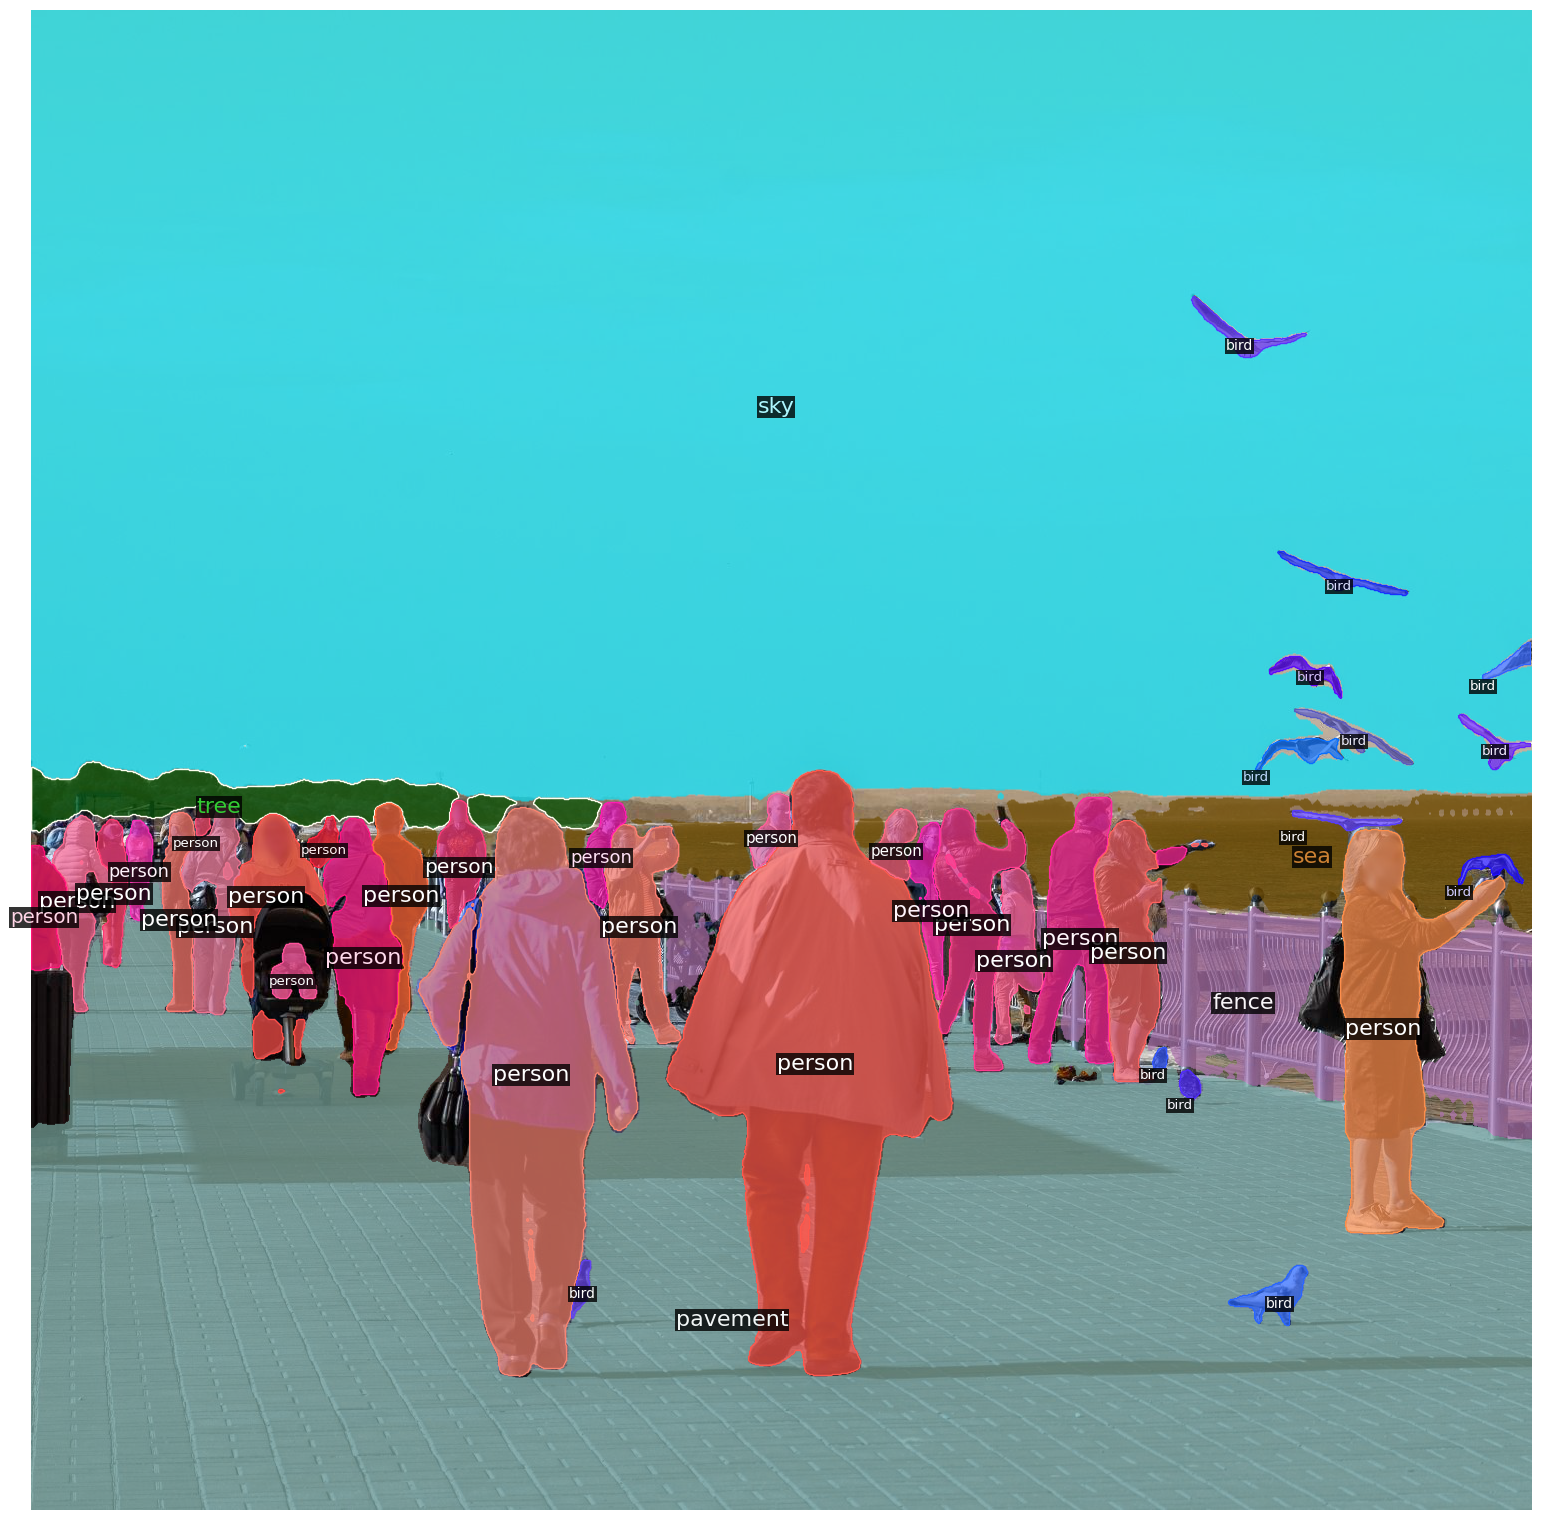

In [9]:
vis = Visualizer(img,metadata=custom_metadata)
vis.draw_panoptic_seg(panoptic_seg.cpu(),segments_info)
display(vis.get_output().fig)
vis.get_output().save(os.path.join(out_path,f'{fname}_pano.jpg'))